# Simulacao leitos - camas limitadas

In [1]:
# Import required modules

import simpy
import random
from random import expovariate, seed
import math
import pandas as pd
import matplotlib.pyplot as plt

## leitos

In [2]:
beds_data = pd.read_csv('cnes_leitos.csv', sep = ';')

In [3]:
beds_data.columns

Index(['CNES', 'IBGE', 'leito_sus_cirurgicos', 'leito_sus_clinicos',
       'leito_sus_gineco_obs', 'leito_sus_isolamento', 'leito_sus_outrasespec',
       'leito_sus_pediatricos', 'leito_sus_uci', 'leito_sus_uti'],
      dtype='object')

In [4]:
beds_data.head()

,CNES,IBGE,leito_sus_cirurgicos,leito_sus_clinicos,leito_sus_gineco_obs,leito_sus_isolamento,leito_sus_outrasespec,leito_sus_pediatricos,leito_sus_uci,leito_sus_uti
0,2516500,110001,0,0,0,0,0,0,0,0
1,2679477,110001,6,21,8,2,0,8,0,0
2,2494280,110002,0,0,0,1,0,30,0,0
3,2494299,110002,16,21,27,0,2,1,0,0
4,2515504,110002,0,0,0,0,0,0,0,0


In [5]:
beds_data['total_beds_uci'] = beds_data['leito_sus_uci'] + beds_data['leito_sus_uti']

In [6]:
normal_beds_sum = ['leito_sus_cirurgicos', 'leito_sus_clinicos', 
                   'leito_sus_isolamento', 'leito_sus_outrasespec',
                   'leito_sus_pediatricos']

In [7]:
beds_data['total_beds'] = beds_data[normal_beds_sum].sum(axis=1)

In [8]:
beds_data_filtered = beds_data[beds_data['IBGE'] == 355030]

In [9]:
beds_simulation = beds_data_filtered[['total_beds', 'total_beds_uci']].sum(axis=0)

In [10]:
beds_simulation[0], int(beds_simulation[0]*(1-0.8))

(12222, 2444)

In [11]:
beds_simulation[1], int(beds_simulation[1]*(1-0.8))

(2421, 484)

## infectados

In [12]:
covid_data = pd.read_csv('dados_covid_sempreUm.csv')

In [13]:
covid_data.head()

,Unnamed: 0,infectados,hospitalizados
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,1
4,4,1,1


In [14]:
covid_data.shape[0]

300

## simulation

In [15]:
class g:
    """g holds Global variables. No individual instance is required"""
    
    has_covid = 1
    covid_cases = covid_data
    cases_arriving = 1390

    
    inter_arrival_time = 1/cases_arriving  # Average time (days) between arrivals
    los = 8  # Average length of stay in hospital (days)
    los_uti = 7  # Average length of stay in hospital (days)
    
    los_covid = 10  # Average length of stay in hospital (days)
    los_covid_uti = 7
    
    sim_duration = covid_data.shape[0]  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    
    total_beds = 12222
    total_beds_icu = 2421
    occupation_rate = 0.8
    icu_occupation_rate = 0.8
    
    icu_rate = 0.1
    icu_after_bed = 0.11
    
    ##beds = int(total_beds * (1 - occupation_rate))  # beds available
    beds = int(total_beds)  # beds available
    ##icu_beds = int(total_beds_icu * (1 - icu_occupation_rate)) # icu beds available
    icu_beds = int(total_beds_icu) # icu beds available

In [16]:
class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Current total icu beds occupied
    6) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        self.patients_in_icu_queue = {}
        
        self.patients_in_beds = {}
        self.patients_in_icu_beds = {}
        
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_icu_beds = []  # List of icu beds occupied at each audit time
        self.audit_queue = []
        self.audit_icu_queue = []
        
        self.bed_count = 0  # Current total beds occupied
        self.bed_icu_count = 0
        self.queue_count = 0
        self.queue_icu_count = 0
        self.admissions = 0  # Admissions to data
        
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """
        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_icu_beds.append(self.bed_icu_count)
        self.audit_queue.append(self.queue_count)
        self.audit_icu_queue.append(self.queue_icu_count)
        
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds
        
        self.audit_report['ICU_Occupied_beds'] = self.audit_icu_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)
        
        self.audit_report['ICU_Median_beds'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['ICU_Beds_5_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.05)
        
        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)
        
        self.audit_report['ICU_Beds_95_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.95)

        # queue
        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)
        
        # icu queue
        self.audit_report['ICU_Queue'] = self.audit_icu_queue

        self.audit_report['ICU_Median_queue'] = \
            self.audit_report['ICU_Queue'].quantile(0.5)

        self.audit_report['ICU_Queue_5_percent'] = \
            self.audit_report['ICU_Queue'].quantile(0.05)

        self.audit_report['ICU_Queue_95_percent'] = \
            self.audit_report['ICU_Queue'].quantile(0.95)

        return self.audit_report

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        
        
        # Plot occupied icu beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied icu beds')
        
        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')
        
        plt.xlabel('Day')
        plt.ylabel('Occupied icu beds')
        plt.title(
            'Occupied icu beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for beds')
        plt.title('Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()
        
        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied ICU beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for ICU bed')
        plt.title('Queue for ICU bed (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return

In [17]:
class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return
    


    def new_admission(self, interarrival_time, los, los_uti):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1
            
            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            
            if g.has_covid == 1:
                p = Patient(patient_id=self.hospital.admissions,
                            los=random.expovariate(1 / ((los + g.los_covid)/2) ),
                            los_uti=random.expovariate(1 / ((los_uti + g.los_covid_uti)/2) ))
                print(g.los_covid)
            else:
                p = Patient(patient_id=self.hospital.admissions,
                            los=random.expovariate(1 / los),
                            los_uti=random.expovariate(1 / los_uti))
            
            #print('Patient %d arriving %7.2f, admissions count %d' %(p.id,self.env.now,self.hospital.admissions))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            
            if g.has_covid == 1:
                inter_arrival_covid = 1 / g.covid_cases['hospitalizados'][math.floor(self.env.now)]
                next_admission = random.expovariate(1/interarrival_time + 1/inter_arrival_covid) 
                ##next_admission = random.expovariate(1 / ((interarrival_time + inter_arrival_covid)/2) )
            else:
                next_admission = random.expovariate(1 / interarrival_time)
            
            
            #next_admission = random.expovariate(1 / interarrival_time)
                        
            yield self.env.timeout(next_admission)

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required
        
        # screening - bed or icu bed
        is_icu = 1 if random.uniform(0, 1) > (1-g.icu_rate) else 0
        
        # bed
        if is_icu == 0:
            
            with self.resources.beds.request() as req:
                # Increment queue count
                self.hospital.queue_count += 1
                #print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add patient to dictionary of queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p

                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield req

                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                #print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add to count of patients in beds and to dictionary of patients in
                # beds
                self.hospital.patients_in_beds[p.id] = p
                self.hospital.bed_count += 1
                #print('Patient %d arriving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))

                # Trigger length of stay delay
                yield self.env.timeout(p.los)
                
                # needs icu
                after_is_icu = 1 if random.uniform(0, 1) > (1-g.icu_after_bed) else 0
                
                if after_is_icu == 1:
                    
                    with self.resources_icu.icu_beds.request() as icu_req:
                    
                        # Increment queue count
                        self.hospital.queue_icu_count += 1
                        #print('Patient %d waiting in icu queue %7.2f, queue icu count %d' %(p.id,self.env.now,self.hospital.queue_icu_count))
                    
                        # Add patient to dictionary of icu queuing patients. This is not used
                        # further in this model.
                        self.hospital.patients_in_icu_queue[p.id] = p
                    
                        # Yield resource request. Sim continues after yield when resources
                        # are vailable (so there is no delay if resources are immediately
                        # available)
                        yield icu_req
                    
                        # Resource now available. Remove from queue count and dictionary of
                        # queued objects
                        self.hospital.bed_count -= 1
                        del self.hospital.patients_in_beds[p.id]
                        #print('Patient %d leaving bed %7.2f, queue bed %d' %(p.id,self.env.now,self.hospital.bed_count))
                    
                        # Increment queue count
                        self.hospital.queue_icu_count -= 1
                        del self.hospital.patients_in_icu_queue[p.id]
                        #print('Patient %d leaving icu queue %7.2f, queue icu count %d' %(p.id,self.env.now,self.hospital.queue_icu_count))
                    
                        # Add to count of patients in icu beds and to dictionary of patients in
                        # icu beds
                        self.hospital.patients_in_icu_beds[p.id] = p
                        self.hospital.bed_icu_count += 1
                        #print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                        # Trigger length of stay delay
                        yield self.env.timeout(p.los_uti)
                
                        # Length of stay complete. Remove patient from counts and
                        # dictionaries
                        self.hospital.bed_icu_count -= 1
                        #print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                        del self.hospital.patients_in_icu_beds[p.id]
                        del self.hospital.patients[p.id]
                        
                else:
                    
                    # Length of stay complete. Remove patient from counts and
                    # dictionaries
                    self.hospital.bed_count -= 1
                    #print('Patient %d leaving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                    del self.hospital.patients_in_beds[p.id]
                
        # icu bed
        else:
                    
            with self.resources_icu.icu_beds.request() as icu_req:
                
                # Increment queue count
                self.hospital.queue_icu_count += 1
                #print('Patient %d arriving icu queue %7.2f, queue icu count %d' %(p.id,self.env.now,self.hospital.queue_icu_count))
                
                # Add patient to dictionary of icu queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_icu_queue[p.id] = p
                
                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield icu_req
                
                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_icu_count -= 1
                del self.hospital.patients_in_icu_queue[p.id]
                #print('Patient %d leaving icu queue %7.2f, icu queue count %d' %(p.id,self.env.now,self.hospital.queue_icu_count))
                
                # Add to count of patients in icu beds and to dictionary of patients in
                # icu beds
                self.hospital.patients_in_icu_beds[p.id] = p
                self.hospital.bed_icu_count += 1
                #print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                # Trigger length of stay delay
                yield self.env.timeout(p.los_uti)
                
                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_icu_count -= 1
                #print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                del self.hospital.patients_in_icu_beds[p.id]
                del self.hospital.patients[p.id]

        return
    
    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds, icu_beds)
        self.resources = Resources(self.env, g.beds)
        self.resources_icu = Resources_ICU(self.env, g.icu_beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los, g.los_uti))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        #self.hospital.chart()

        return

In [18]:
class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los, los_uti):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los
        self.los_uti = los_uti

        return

In [19]:
class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return

In [20]:
class Resources_ICU:
    """
    Holds icu beds resources
    """

    def __init__(self, env, number_of_icu_beds):
        """        Constructor method to initialise icu beds resource)"""
        self.icu_beds = simpy.Resource(env, capacity=number_of_icu_beds)

        return

In [21]:
def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return

In [22]:
## Code entry point. Calls main method.
#if __name__ == '__main__':
#    main()

In [23]:
model = Model()

In [24]:
%%time
seed(98989)
model.run()

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

KeyboardInterrupt: 

In [25]:
model.hospital.build_audit_report().head()

,Time,Occupied_beds,ICU_Occupied_beds,Median_beds,ICU_Median_beds,Beds_5_percent,ICU_Beds_5_percent,Beds_95_percent,ICU_Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent,ICU_Queue,ICU_Median_queue,ICU_Queue_5_percent,ICU_Queue_95_percent
0,20,9930,1651,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,21,10114,1681,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
2,22,10224,1695,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
3,23,10346,1725,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
4,24,10498,1727,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [26]:
model.hospital.build_audit_report().tail()

,Time,Occupied_beds,ICU_Occupied_beds,Median_beds,ICU_Median_beds,Beds_5_percent,ICU_Beds_5_percent,Beds_95_percent,ICU_Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent,ICU_Queue,ICU_Median_queue,ICU_Queue_5_percent,ICU_Queue_95_percent
6,26,10706,1752,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
7,27,10845,1766,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
8,28,10917,1754,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
9,29,10907,1765,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
10,30,10923,1802,10556.0,1752.0,10022.0,1666.0,10920.0,1784.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0


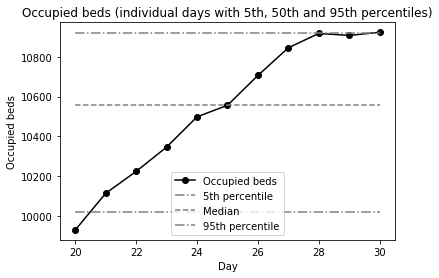

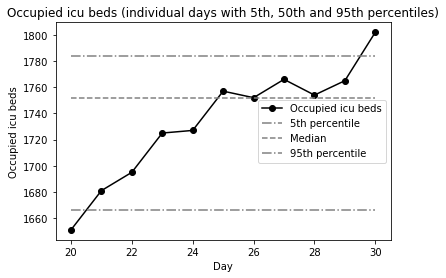

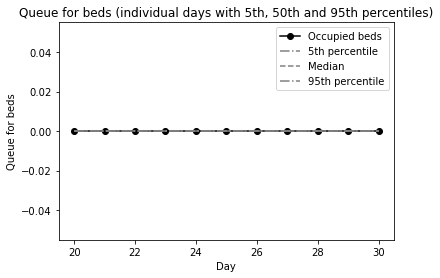

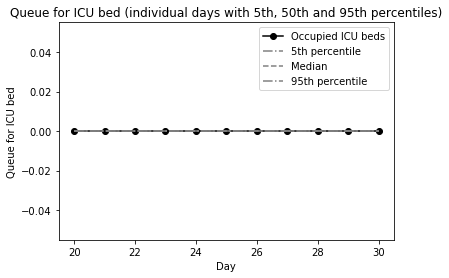

In [27]:
model.hospital.chart()